In [36]:
import numpy as np

###########
# constants
###########

n =  10  # number of PCBsats left in cubesat
m_stac = 10 * (10 ** -3)  # mass of individual stac (KILOGRAMS)

#R_z_dot = # tbd, this is our stack velocity in the z direction
#R_z = # array of vertical positions of each stack

dt = 1  # SECONDS

#w_motor =  # motor ang velocity (radians per second)
#l_screw =  # screw lead (meters)
#r_screw =  # screw radius (meters)
#v =  (w_motor * l_screw) / (2 * np.pi)  # linear velocity of screw shaft (meters per second)

# 3x3 matrix for moment of inertia of cubesat without stacs
MOI_cube = np.array([
    [1308846.485, -10374.412, -13883.462],
    [-10374.412, 1334376.646, -21514.642],
    [-13883.462,-21514.642, 671472.124]]) / 1000000

# 3x3 matrix giving moment of inertia of an individual stac about it's own axis
MOI_stac = np.array([
    [1/12 * (10.1 ** (-4)), 0, 0],
    [0, 1/12 * (10.1 ** (-4)), 0], 
    [0, 0, 1/60000]
])

# nx3 length v giving the x y z locations of the stacs
positions = np.array([
    [0, 0, 7.5],
    [0, 0, 9],
    [0, 0, 10.5],
    [0, 0, 12],
    [0, 0, 13.5],
    [0, 0, 15],
    [0, 0, 16.5],
    [0, 0, 18],
    [0, 0, 19.5],
    [0, 0, 21]
])

##################
# helper functions
##################

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@ double check correctness
def v_shaft(w_motor, l_screw):
    return (w_motor * l_screw) / (2 * np.pi)

# note that R_z_dot 
#def make_J_dot(R_x, R_y, R_z_dot, n):
#    xz = -n * m_stac * R_x * R_z_dot
#    yz = -n * m_stac * R_y * R_z_dot
#    return np.matrix([[0,  0,  xz],
#                     [0,  0,  yz],
#                      [xz, yz, 0]])

#find moment of inertia of cubesat

def inertia_of_cubesat(MOI_cube, MOI_stac, n, positions):
    
    MOI_mat = np.empty([3,3])
        
    for i in range(3):
        for j in range(3):
            
            ab = 0
            
            for x in range(n):
                if i != j:
                    g = 0
                else:
                    g = positions[x,i] * positions[x,j]

            ab += g  
            
        MOI_mat[i,j] = MOI_cube[i,j] + n * MOI_stac[i,j] + m_stac*ab
        
    return MOI_mat
            
    






### TBD
* update stac vertical positions at each time step
* compute inertial matrix based on positions
* encode some way of adjusting inertial matrix when a stac is released (if z > threshold: DECREASE N BY ONE??)
* 
* NEW PLAN
* use `inertia_of_cubesat` function to instantiate initial inertia matrix
* gather the vertical positions of the terms in `positions`, our nx3 matrix of the pcb positions (impleentation can either pick out all the `z` terms and save in new matrix since these are the only things we care about, or we can just reuse `positions`)
* update `z` values of `positions` after some time step, `dt`.
*      if any positions are updated beyond threshold (`z > threshold`) remove them. I THINK WE CAN JUST DECREASE N BY COUNT of BELOW THRESHOLD
*      recompute inertia matrix on update `positions`
*      store result. I don't think we need to save ALL of the intermediate `positions`, just the most recent one

In [37]:
# ========================
# dynamics
# ========================

I = inertia_of_cubesat(MOI_cube, MOI_stac, n, positions) # current inertial matrix

inertial_matrix_eigenvalues = [np.linalg.eig(I)[0]]

# NOTE: the following variables are lists, appended with
# calculations at each time step. should start with initial val
v_stac = []
angVel = []
                      
# CONSTANTS
# dt defined above
# w_motor :: ang vel provided by motor, acting on leadscrew
# torqueCube :: torque from coil, reaction wheel, whatever we decide on
THRESHOLD = 22.5 # defines vertical position at which pcb has left the cubesat

def update_dynamics(w_motor, torqueCube, dt):
    global n
    global I
    
    # computes/updates new stac velocity
    #v = v_shaft(w_motor, l_screw)  UNCOMMENT IF WE WANT TO USE VARIABLE STAC VELOCITY
    v = 0.254 * 0.01
    v_stac.append(v)
    
    # z_dot = vertical displacement of pcb's
    z_dot = v * dt
    
    # update positions
    count = 0
    for row in range(n):
        # new_z = z + z_dot
        new_z = positions[row][2] + z_dot
        
        # update positions
        positions[row][2] = new_z
        
        # count number pcb's which left cubesat
        if new_z >= THRESHOLD:
            count += 1      
            
    # decrease number of pcbs in satellite by `count`
    n -= count
    
    if (n <= 0):
        print("all PCBsats removed. aborting")
        return
    
    # compute new inertia matrix with updated positions + number of pcb's
    I = inertia_of_cubesat(MOI_cube, MOI_stac, n, positions)
    inertial_matrix_eigenvalues.append(np.linalg.eig(I)[0])
    
    # computes/updates new angular velocity
    #angAccel = np.linalg.inv(I[-2]) * torqueCube
    #angVel.append(angVel[-1] + angAccel * dt)
    
# ========================
# simulation
# ========================

# fills in I, v_stac, angVel lists at each time step in (start, end)

start = 0
end = 60*100

for i in np.arange(start, end+dt, dt):
    if (n != 0):
        update_dynamics(n, 0, dt)

all PCBsats removed. aborting


In [38]:
inertial_matrix_eigenvalues[0]

array([ 0.        ,  0.        ,  5.08163879])

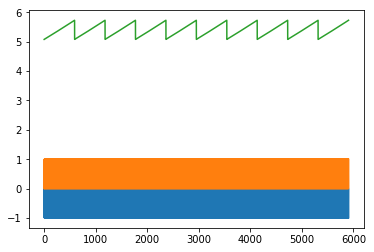

In [45]:
import matplotlib.pyplot as plt
x = [val[0] for val in inertial_matrix_eigenvalues]
y = [val[1] for val in inertial_matrix_eigenvalues]
z = [val[2] for val in inertial_matrix_eigenvalues]

plt.plot(np.arange(start, len(x), dt), x)
plt.plot(np.arange(start, len(y), dt), y)
plt.plot(np.arange(start, len(z), dt), z)